In [80]:
import importlib
import numpy as np
import matplotlib.pyplot as plt

from fenics import *
from utils.colors import *
from utils.mesh_utils import get_square_f
from algorithms.matrix_free_rsvd import MatrixFreeRSVD, get_approximate_W, tikhonov_solver
from algorithms.dynamic_low_rank_solver import DynamicLowRankSolver
import algorithms.dynamic_low_rank_solver
importlib.reload(algorithms.dynamic_low_rank_solver)
from algorithms.dynamic_low_rank_solver import DynamicLowRankSolver

SEED = 15

For $i=1,\dots,\text{max\_iter}$, do 
1. Update $W$
	1. $W = U_x \Sigma_x$
	2. $W' = W - \alpha \nabla \Phi(x) V_x$
	3. $\hat U = \operatorname{orth}(\begin{bmatrix}U_x & W'\end{bmatrix})$
2. Update $L$
	1. $L = V_x \Sigma_x^T$
	2. $L' = L - \alpha \nabla \Phi^T U_x$
	3. $\hat V = \operatorname{orth}(\begin{bmatrix}V_x & L'\end{bmatrix})$
3. Update $S$
	1. $S = (\hat U^T U_x) \Sigma_x (V_x^T \hat V)$
	2. $\hat S = S - \alpha \hat U^T \Phi(x) \hat V$
4. Set $U_x, \Sigma_x, V_x = \operatorname{truncate}(\hat U, \hat \Sigma, \hat V)$


In [78]:
def problem_setup(n, k):
    mesh = UnitSquareMesh(n, n)
    V_h = FunctionSpace(mesh, 'CG', 1)

    mfrsvd = MatrixFreeRSVD(V_h)
    x0, y0, width, height = 0.1, 0.7, 0.15, 0.15
    f = get_square_f(V_h, x0, y0, w=width, h=height)
    x = f.vector().get_local()
    y = mfrsvd.apply_K(x)

    # Approximate SVD K = U S V^T and weights W
    Uk, Sk, VkT = mfrsvd.mf_rsvd(k=k, seed=SEED)
    w = get_approximate_W(VkT.T, mfrsvd.M_dx)
    return V_h, y, x, w, mfrsvd


V_h, y, x, w, mfrsvd = problem_setup(n=64, k=25)

[##############################] 5000/5000 (diff=7.9e-04)


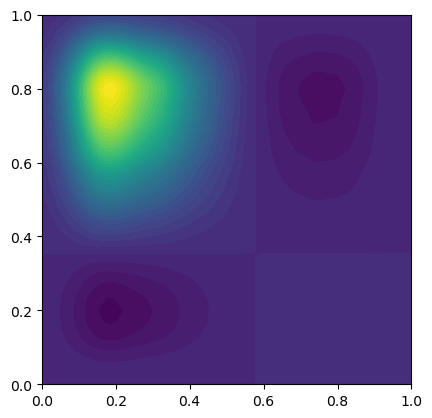

In [81]:
solver = DynamicLowRankSolver(mfrsvd, x_true=x)
f = solver.solve_cg(
    y, w,
    lambda_=1e-4,
    max_rank=1,
    rho=0.0,
    alpha_cg=2000,
    tol=1e-6,
)
plot(f);
error_cg = solver.errors.copy()

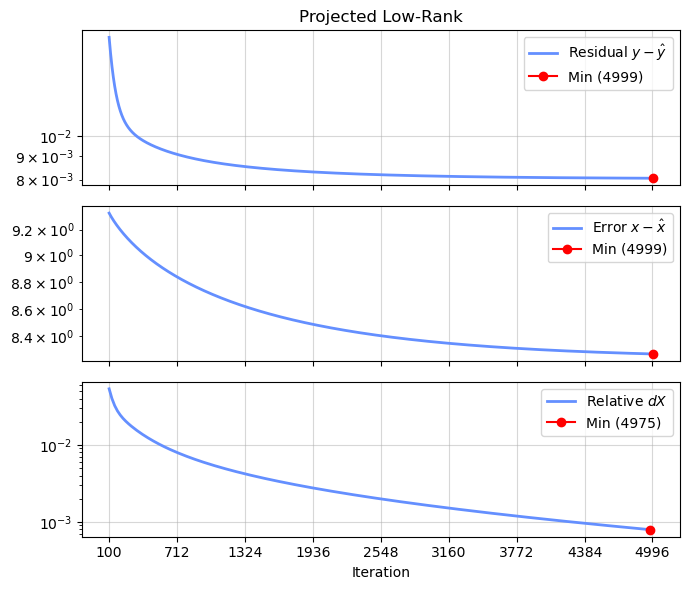

In [82]:
plot_records(solver, title="Projected Low-Rank", xmin=100)

[##############################] 5000/5000 (diff=1.1e-02)


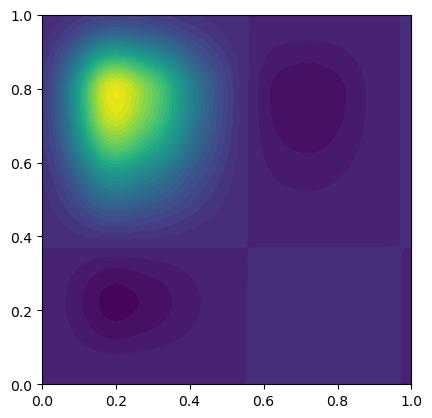

In [98]:
solver = DynamicLowRankSolver(mfrsvd, x_true=x)
f = solver.solve(
    y, w,
    lambda_=1e-4,
    max_rank=1,
    rho=0,
    tol=1e-6
)
errors_gd = solver.errors.copy()
plot(f);


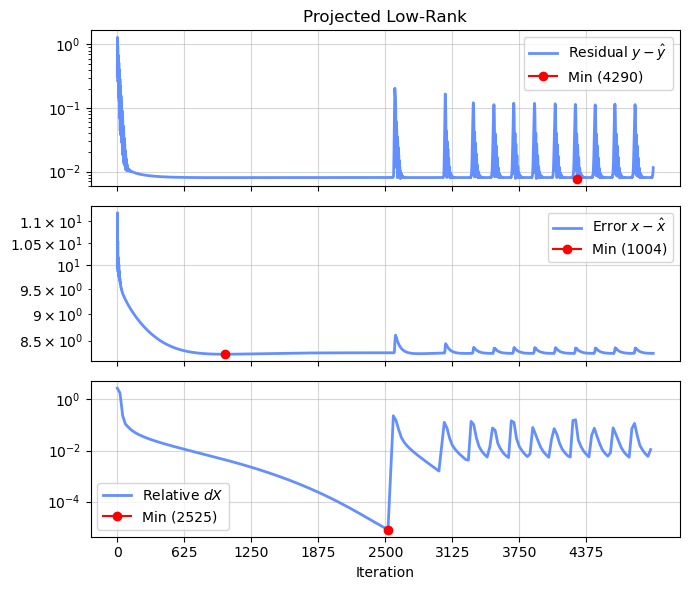

In [99]:
def plot_records(solver: DynamicLowRankSolver, title=None, xmin=0, ylim=None):

    fig, axes = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
    ax1, ax2, ax3 = axes

    X_rel   = solver.X_rel[xmin // 25:]
    residuals  = solver.residuals[xmin:]
    errors = solver.errors[xmin:]

    # x-axis for dX (every 25th point)
    nx = len(X_rel)
    xx = np.arange(0, nx * 25, 25) + xmin

    # x-axis for others
    no = len(residuals)
    xo = np.arange(0, no) + xmin
    
    ax1.semilogy(xo, residuals, label='Residual $y - \hat y$',  c=C2[0], lw=2)
    ax2.semilogy(xo, errors,    label='Error $x - \hat x$',     c=C2[0], lw=2)
    ax3.semilogy(xx, X_rel,     label='Relative $dX$', c=C2[0], lw=2)

    # Mark the minimum points
    idxmin_r = np.argmin(residuals)
    idxmin_e = np.argmin(errors)
    idxmin_x = np.argmin(X_rel)
    ax1.semilogy(xo[idxmin_r], residuals[idxmin_r], marker='o', c='r', label=f'Min ({xo[idxmin_r]})')
    ax2.semilogy(xo[idxmin_e], errors[idxmin_e],    marker='o', c='r', label=f'Min ({xo[idxmin_e]})')
    ax3.semilogy(xx[idxmin_x], X_rel[idxmin_x],     marker='o', c='r', label=f'Min ({xx[idxmin_x]})')

    for ax in axes:
        ax.legend()
        ax.grid(alpha=0.5)
        ax.set_xticks(np.arange(0, no, no // 8) + xmin)
        ax.set_ylim(ylim)
    
    ax1.set_title(title)
    ax3.set_xlabel("Iteration")
    plt.tight_layout()
    plt.show()


plot_records(solver, title="Projected Low-Rank", xmin=0)

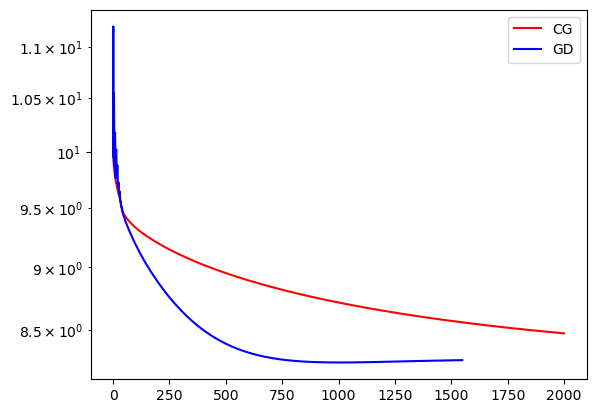

In [86]:
s, t = 0, 2000
plt.semilogy(error_cg[s:t], label='CG', c='r')
plt.semilogy(errors_gd[s:t], label='GD', c='b')
plt.legend()
plt.show()
